In [ ]:
! pip install matplotlib pandas seaborn
! pip install statsmodels
! pip install pytest
! pip install numpy nibabel nilearn neuroimagingtools
! pip install rsatoolbox
! pip install PcmPy
! pip install h5py
! pip install mat73

In [47]:
import scipy.io as sio
import h5py
import mat73
import rsatoolbox as rsa
from rsatoolbox.io import spm as spm_io
import matplotlib.pyplot as plt
import os
import sys
import numpy as np
import pandas as pd
import surfAnalysisPy as surf
import SUITPy as suit
import nibabel as nb
import nitools as nt
from matplotlib.cm import ScalarMappable
import matplotlib.cm as cm
import matplotlib.colors as mcolors
from pathlib import Path
import seaborn as sns
import PcmPy as pcm
import glob
import matplotlib.patches as patches

# SET PATHS:
# baseDir = '/Users/alighavam/Desktop/Projects/bimanual_wrist/data/fMRI'
baseDir = '/Users/alighavampour/Desktop/Projects/bimanual_wrist/data/fMRI'
bidsDir = 'BIDS'
anatomicalDir = 'anatomicals'
freesurferDir = 'surfaceFreesurfer'
surfacewbDir = 'surfaceWB' 
behavDir = 'behavioural'
regDir = 'ROI'
atlasDir = '/Volumes/diedrichsen_data$/data/Atlas_templates/fs_LR_32'


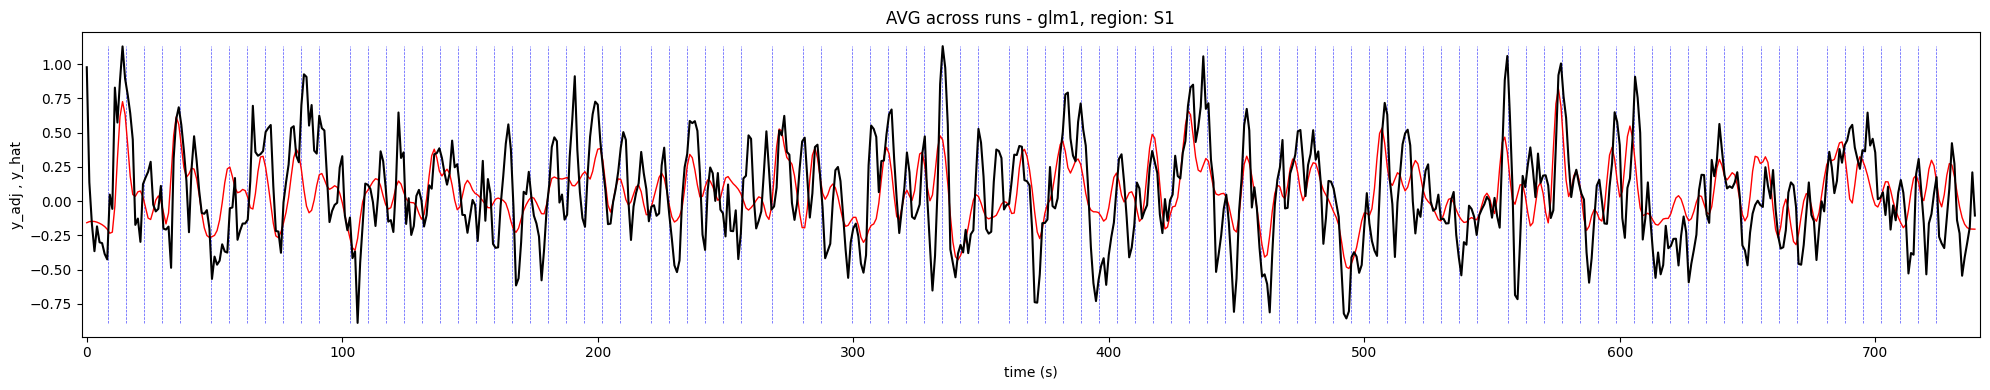

In [ ]:
sn = 7
glm = 1
ses = 2
region = 1

participants = [7]
sessions = [1,2]
for sn in participants:
    for ses in sessions:
        # for cutting time series:
        pre_idx = 8
        post_idx = 22
        TR = 1

        roi_names = ['', 'S1', 'M1', 'PMd', 'PMv', 'SMA', 'V1', 'SPLa', 'SPLp']

        D = pd.read_table(os.path.join(baseDir, behavDir, f's{sn:02d}', f'ses-{ses:02d}', f'BimanualWrist_MR_{sn}.dat'))
        T = sio.loadmat(os.path.join(baseDir, regDir, f's{sn:02d}', f'ses-{ses:02d}', f'time_series_glm{glm}.mat'), simplify_cells=True)
        # SPM = sio.loadmat(os.path.join(baseDir, f'glm{glm}', f's{sn:02d}', f'ses-{ses:02d}', 'SPM.mat'), simplify_cells=True)
        # SPM = SPM['SPM']
        SPM = mat73.loadmat(os.path.join(baseDir, f'glm{glm}', f's{sn:02d}', f'ses-{ses:02d}', 'SPM.mat'))
        SPM = SPM['SPM']

        runs = np.unique(D['BN'])
        X = SPM['xX']['X']
        y_pred = np.sum(X[0:740, :], axis=1) - np.mean(np.sum(X[0:740, :], axis=1))
        y_adj = T['y_adj']
        y_hat = T['y_hat']
        y_run_avg = np.zeros(740)
        y_hat_avg = np.zeros(740)
        y_pred = np.sum(SPM['xX']['X'][:740, :], axis=1) - np.mean(np.sum(SPM['xX']['X'][:740, :], axis=1))
        y_pred = y_pred * 50
        for run in range(0, len(runs)):
            row = SPM['Sess'][run]['row'].astype(int) - 1
            t = np.arange(0, len(row), 1)
            ons = D[D['BN']==run+1]['startTimeReal'].values.flatten()/1000

            fig, ax = plt.subplots(1, 1, figsize=(20, 4))
            ax.vlines(ons, ymin=min(y_adj[row, region]), ymax=max(y_adj[row, region]), colors='b', lw=0.5, alpha=0.7, linestyles='--')
            # plt.plot(t, y_pred, color='r', ls='--', lw=0.7, alpha=0.6)
            plt.plot(t, y_hat[row, region], color='r', lw=1.5)
            plt.plot(t, y_adj[row, region], color='k', lw=1)
            plt.xlabel('time (s)')
            plt.ylabel('y adj')
            plt.xlim((t[0]-2, t[-1]+2))
            plt.title(f'run {run+1} - glm{glm}, region: {roi_names[region]}')
            plt.tight_layout()
            plt.savefig(f'./figures/bmw_time_s{sn:02d}_glm{glm}_ses{ses}_run{run+1:02d}_{roi_names[region]}.pdf', bbox_inches="tight")
            # plt.show()
            plt.close()
            y_run_avg += y_adj[row, region]/len(runs)
            y_hat_avg += y_hat[row, region]/len(runs)

        fig, ax = plt.subplots(1, 1, figsize=(20, 4))
        ax.vlines(ons, ymin=min(y_run_avg), ymax=max(y_run_avg), colors='b', lw=0.5, alpha=0.7, linestyles='--')
        # plt.plot(t, y_pred, color='r', ls='--', lw=0.7, alpha=0.6)
        plt.plot(t, y_hat_avg, color='r', lw=1)
        plt.plot(t, y_run_avg, color='k', lw=1.5)
        plt.xlabel('time (s)')
        plt.ylabel('y_adj , y_hat')
        plt.xlim((t[0]-2, t[-1]+2))
        plt.title(f'AVG across runs - glm{glm}, region: {roi_names[region]}')
        plt.tight_layout()
        # plt.savefig(f'./figures/efcp_Yadj_Yhat_glm{glm}_ses{ses}_avg_{roi_names[region]}.pdf', bbox_inches="tight")
        plt.show()

        '''
        ||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||
        TIME LOCKING AND AVERAGING THE TIME SERIES 
        ||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||
        '''
        def extract_snippets(y, pre, post, onsets):
            snippets_y = []

            for onset in onsets:
                start_idx = onset - pre
                end_idx = onset + post

                snippet_y = np.full(pre + post + 1, np.nan)
                
                valid_start = int(max(0, start_idx))
                valid_end = int(min(len(y), end_idx + 1))
                
                insert_start = int(valid_start - start_idx)
                insert_end = int(insert_start + (valid_end - valid_start))

                snippet_y[insert_start:insert_end] = y[valid_start:valid_end]
                
                snippets_y.append(snippet_y)
                    
            return np.array(snippets_y)

        # load the events:
        events = pd.read_table(os.path.join(baseDir, behavDir, f's{sn:02d}', f'ses-{ses:02d}', f'glm{glm}_events.tsv'))

        # find the onsets of the events:
        # T = events.copy()
        # T['y_adj'] = np.nan
        # T['y_hat'] = np.nan
        T = pd.DataFrame()

        blocks = np.unique(events['BN'])
        for r in range(np.shape(y_adj)[1]):
            for i, BN in enumerate(blocks):
                tmp = pd.DataFrame()
                y_adj_reg = y_adj[SPM['Sess'][i]['row'].astype(int)-1, r]
                y_hat_reg = y_hat[SPM['Sess'][i]['row'].astype(int)-1, r]
                onsets = events[events['BN']==BN]['onset']
                y_adj_cut = extract_snippets(y_adj_reg, pre_idx, post_idx, onsets)
                y_hat_cut = extract_snippets(y_hat_reg, pre_idx, post_idx, onsets)

                tmp = pd.concat([tmp, events[events['BN']==BN]], axis=1).reset_index(drop=True)
                tmp['region'] = r

                col_names = [f"y_adj{i}" for i in range(y_adj_cut.shape[1])]
                df_y_adj = pd.DataFrame(y_adj_cut, columns=col_names)
                tmp = pd.concat([tmp, df_y_adj], axis=1).reset_index(drop=True)

                col_names = [f"y_hat{i}" for i in range(y_hat_cut.shape[1])]
                df_y_hat = pd.DataFrame(y_hat_cut, columns=col_names)
                tmp = pd.concat([tmp, df_y_hat], axis=1).reset_index(drop=True)
                
                T = pd.concat([T, tmp], axis=0).reset_index(drop=True)

        T.to_csv(os.path.join(baseDir, regDir, f's{sn:02d}', f'ses-{ses:02d}', f'bmw_time_series_cut_glm{glm}.csv'), index=False)


## TIME SERIES CUT

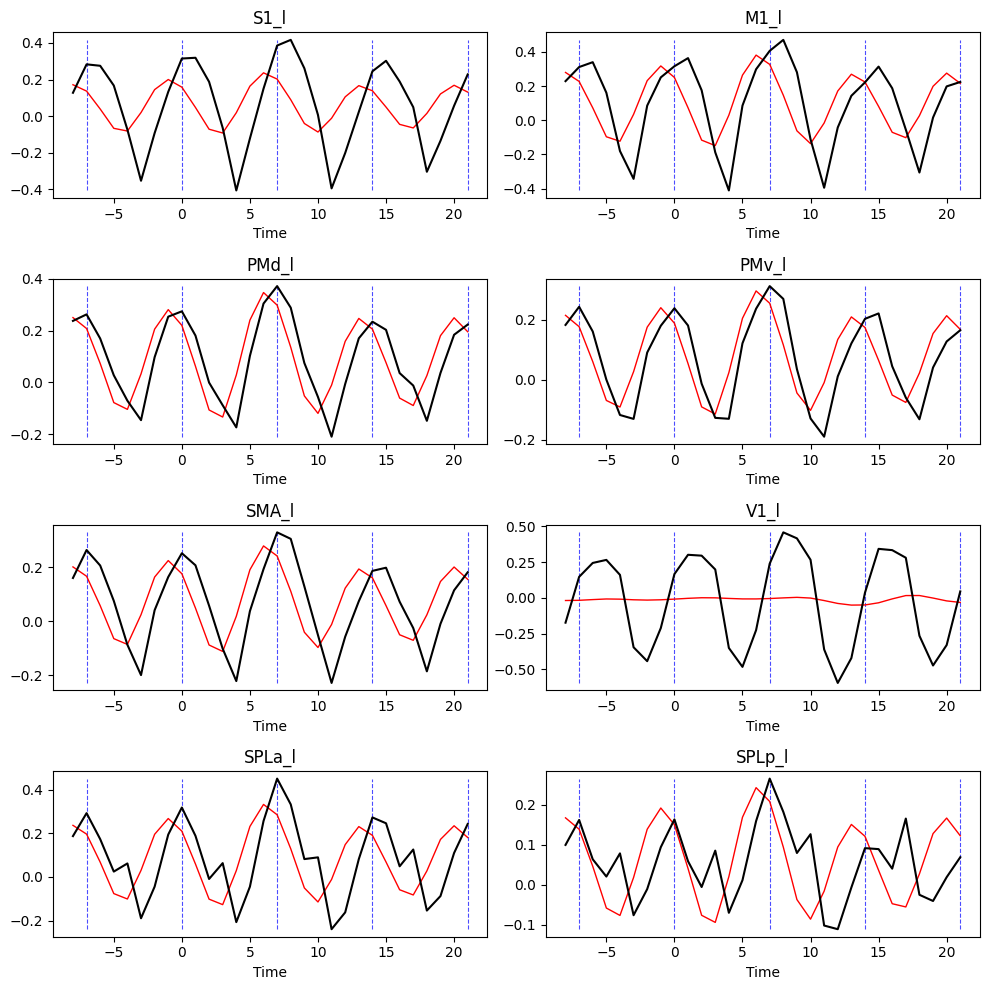

In [ ]:
sn = 7
glm = 1
ses = 2

T = pd.read_csv(os.path.join(baseDir, regDir, f's{sn:02d}', f'ses-{ses:02d}', f'time_series_cut_glm{glm}.csv'))
# T = T[T['repetition']==1]
t = np.arange(-8, 22, 1)
roi_names = ['_l', 'S1_l', 'M1_l', 'PMd_l', 'PMv_l', 'SMA_l', 'V1_l', 'SPLa_l', 'SPLp_l', '_r', 'S1_r', 'M1_r', 'PMd_r', 'PMv_r', 'SMA_r', 'V1_r', 'SPLa_r', 'SPLp_r']

n_row = 4
n_col = 2
fig, axes = plt.subplots(n_row, n_col, figsize=(10, 10))
for j, r in enumerate(range(1,9)):
    y_adj = T.loc[T['region']==r, [f'y_adj{i}' for i in range(len(t))]].mean().to_list()
    y_hat = T.loc[T['region']==r, [f'y_hat{i}' for i in range(len(t))]].mean().to_list()

    ax = axes[j//n_col, j%n_col]
    ax.vlines([-7,0,7,14,21], ymin=min(min(y_adj),min(y_hat)), ymax=max(max(y_adj),max(y_hat)), color='b', ls='--', lw=0.8, alpha=0.7)
    ax.plot(t, y_hat, color='r', lw=1)
    ax.plot(t, y_adj, color='k', lw=1.5)
    ax.set_title(f'{roi_names[r]}')
    ax.set_xlabel('Time')

plt.tight_layout()
# plt.savefig(f'./figures/efcp_Yhat_Yadj_my_glm{glm}_ses{ses}.pdf', bbox_inches="tight")
plt.show()